<b>Important:</b> Save prepared/modified datasets locally to <code>../data/prepared/</code>


In [1]:
import sys
import pickle
import numpy as np
from numpy import array, ndarray
from pandas import read_csv, DataFrame, Series, concat
from matplotlib.pyplot import figure, savefig, show, subplots
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from scipy.stats import norm, expon, lognorm
from sklearn.neighbors import KNeighborsClassifier

sys.path.insert(1, '../../../../utils')
from dslabs_functions import get_variable_types, \
  CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_bar_chart, plot_multiline_chart, plot_evaluation_results, \
  plot_horizontal_bar_chart, HEIGHT, plot_line_chart, dummify, run_NB, run_KNN, plot_multibar_chart, \
  encode_cyclic_variables, plot_confusion_matrix
from studies import naive_Bayes_study, knn_study, evaluate_approach, evaluate_and_plot 


In [2]:
filename = "../../data/raw/traffic_accidents.csv"
file_tag = "traffic"
lab_folder = "lab3_preparation/encodings"
target_name = "crash_type"
data: DataFrame = read_csv(filename, na_values="")
variable_types: dict[str, list] = get_variable_types(data)
data.shape

(209306, 24)

In [3]:
data.head()

,crash_date,traffic_control_device,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,...,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
0,2023-07-29 13:00:00,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,13,7,7
1,2023-08-13 00:11:00,TRAFFIC SIGNAL,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0,1,8
2,2021-12-09 10:30:00,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,10,5,12
3,2023-08-09 19:55:00,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,ANGLE,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,...,NONINCAPACITATING INJURY,5.0,0.0,0.0,5.0,0.0,0.0,19,4,8
4,2023-08-19 14:55:00,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,14,7,8


In [4]:
numeric_vars = variable_types['numeric']
data[numeric_vars].head()

,num_units,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
0,2,0.0,0.0,0.0,0.0,0.0,3.0,13,7,7
1,2,0.0,0.0,0.0,0.0,0.0,2.0,0,1,8
2,3,0.0,0.0,0.0,0.0,0.0,3.0,10,5,12
3,2,5.0,0.0,0.0,5.0,0.0,0.0,19,4,8
4,2,0.0,0.0,0.0,0.0,0.0,3.0,14,7,8


In [5]:
symbolic_vars = variable_types['symbolic']
data[symbolic_vars].head()

,traffic_control_device,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,damage,prim_contributory_cause,most_severe_injury
0,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,"$501 - $1,500",UNABLE TO DETERMINE,NO INDICATION OF INJURY
1,TRAFFIC SIGNAL,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",IMPROPER TURNING/NO SIGNAL,NO INDICATION OF INJURY
2,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"$501 - $1,500",FOLLOWING TOO CLOSELY,NO INDICATION OF INJURY
3,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,ANGLE,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,"OVER $1,500",UNABLE TO DETERMINE,NONINCAPACITATING INJURY
4,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,"$501 - $1,500",DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,NO INDICATION OF INJURY


In [6]:
encoding_analysis = []

for var in symbolic_vars:
    counts = data[var].value_counts()
    total = len(data[var])

    encoding_analysis.append({
        'Variable': var,
        'Cardinality': len(counts),
        'Most Frequent': counts.index[0],
        'Most Freq Count': counts.iloc[0],
        'Most Freq %': f"{(counts.iloc[0] / total * 100):.1f}%",
        'Least Frequent': counts.index[-1],
        'Least Freq Count': counts.iloc[-1],
        'Least Freq %': f"{(counts.iloc[-1] / total * 100):.2f}%",
        'Missing Values': data[var].isna().sum(),
        'Missing %': f"{(data[var].isna().sum() / total * 100):.2f}%"
    })

encoding_df = DataFrame(encoding_analysis)
encoding_df

,Variable,Cardinality,Most Frequent,Most Freq Count,Most Freq %,Least Frequent,Least Freq Count,Least Freq %,Missing Values,Missing %
0,traffic_control_device,19,TRAFFIC SIGNAL,123944,59.2%,BICYCLE CROSSING SIGN,11,0.01%,0,0.00%
1,weather_condition,12,CLEAR,164700,78.7%,"BLOWING SAND, SOIL, DIRT",1,0.00%,0,0.00%
2,lighting_condition,6,DAYLIGHT,134109,64.1%,DAWN,3724,1.78%,0,0.00%
3,first_crash_type,18,TURNING,64157,30.7%,TRAIN,8,0.00%,0,0.00%
4,trafficway_type,20,NOT DIVIDED,77753,37.1%,L-INTERSECTION,127,0.06%,0,0.00%
5,alignment,6,STRAIGHT AND LEVEL,204590,97.7%,CURVE ON HILLCREST,53,0.03%,0,0.00%
6,roadway_surface_cond,7,DRY,155905,74.5%,"SAND, MUD, DIRT",40,0.02%,0,0.00%
7,road_defect,7,NO DEFECTS,171730,82.0%,DEBRIS ON ROADWAY,139,0.07%,0,0.00%
8,damage,3,"OVER $1,500",147313,70.4%,$500 OR LESS,20783,9.93%,0,0.00%
9,prim_contributory_cause,40,UNABLE TO DETERMINE,58316,27.9%,MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT,7,0.00%,0,0.00%


### **Encoding** ###

In [7]:
task = "encoding"

# Define encoding helper functions
def target_encode(df: DataFrame, var: str, target: str, smoothing: float = 10.0) -> Series:
    """
    Target encoding: replace each category with the mean of the target for that category.
    Uses smoothing to prevent overfitting on rare categories.
    """
    global_mean = df[target].mean()
    agg = df.groupby(var)[target].agg(['mean', 'count'])
    # Smoothed target encoding
    smooth = (agg['count'] * agg['mean'] + smoothing * global_mean) / (agg['count'] + smoothing)
    return df[var].map(smooth)

def frequency_encode(df: DataFrame, var: str) -> Series:
    """
    Frequency encoding: replace each category with its frequency (count / total).
    Useful for high cardinality variables where order doesn't matter.
    """
    freq = df[var].value_counts(normalize=True)
    return df[var].map(freq)

def binary_dominant_encode(df: DataFrame, var: str, dominant_value: str) -> Series:
    """
    Binary encoding: 1 if the value is the dominant category, 0 otherwise.
    Useful for highly skewed categorical variables.
    """
    return (df[var] == dominant_value).astype(int)

def group_rare_categories(df: DataFrame, var: str, min_pct: float = 0.01) -> Series:
    """
    Group rare categories (those below min_pct threshold) into 'OTHER'.
    """
    counts = df[var].value_counts(normalize=True)
    rare_categories = counts[counts < min_pct].index.tolist()
    result = df[var].copy()
    result[result.isin(rare_categories)] = 'OTHER'
    return result

print("Encoding helper functions defined:")
print("- target_encode: Uses target variable mean per category (with smoothing)")
print("- frequency_encode: Uses category frequency as encoding")
print("- binary_dominant_encode: Binary encoding for highly skewed variables")
print("- group_rare_categories: Groups rare categories into 'OTHER'")

Encoding helper functions defined:
- target_encode: Uses target variable mean per category (with smoothing)
- frequency_encode: Uses category frequency as encoding
- binary_dominant_encode: Binary encoding for highly skewed variables
- group_rare_categories: Groups rare categories into 'OTHER'


### Approach 1 - Ordinal and One-Hot encoding

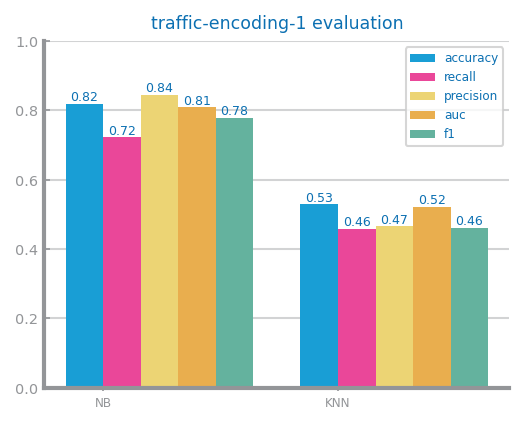

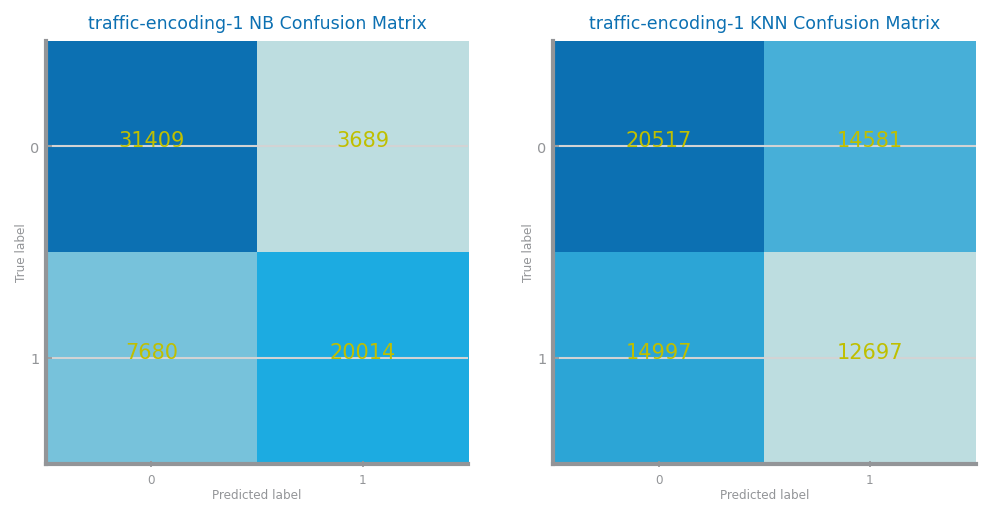

In [8]:
approach_1 = "encoding-1"

ordinal_vars = {
    "damage": {"$500 OR LESS": 0, "$501 - $1,500": 1, "OVER $1,500": 2},
    "most_severe_injury": {"NO INDICATION OF INJURY": 0, "REPORTED, NOT EVIDENT": 1, "NONINCAPACITATING INJURY": 2, "INCAPACITATING INJURY": 3, "FATAL": 4},
    "intersection_related_i": {"N": 0, "Y": 1},
    target_name: {"NO INJURY / DRIVE AWAY": 0, "INJURY AND / OR TOW DUE TO CRASH": 1 }
}
dummy_vars = [var for var in symbolic_vars if var not in ordinal_vars]

data_enc1 = data.replace(ordinal_vars, inplace=False)
data_enc1 = dummify(data_enc1, dummy_vars)
data_enc1['crash_date'] = data_enc1['crash_date'].astype(int)

evaluate_and_plot(data_enc1, lab_folder, file_tag, approach_1, target_name)

### Approach 2 - Frequency Encoding for High-Cardinality. 

This approach uses **frequency encoding** instead, which is completely target-independent.

1. Ordinal encoding applied: damage, most_severe_injury, intersection_related_i, crash_type
2. Binary dominant encoding: alignment, road_defect
3. Frequency encoding applied: traffic_control_device, trafficway_type, first_crash_type, prim_contributory_cause
4. Grouped + One-hot encoding: weather_condition, roadway_surface_cond, lighting_condition

Final dataset shape: (209306, 38)


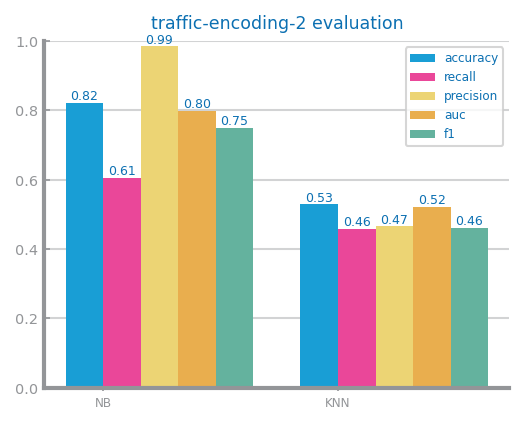

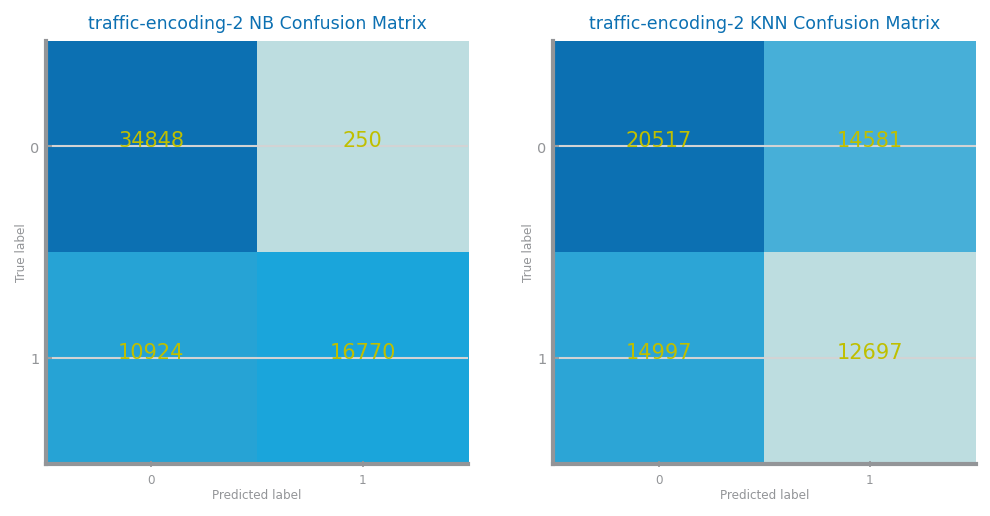

In [9]:
approach_2 = "encoding-2"

# Start with a copy of original data
data_enc2 = data.copy()

# 1. ORDINAL ENCODING - Variables with natural order
ordinal_vars = {
    "damage": {"$500 OR LESS": 0, "$501 - $1,500": 1, "OVER $1,500": 2},
    "most_severe_injury": {"NO INDICATION OF INJURY": 0, "REPORTED, NOT EVIDENT": 1, 
                          "NONINCAPACITATING INJURY": 2, "INCAPACITATING INJURY": 3, "FATAL": 4},
    "intersection_related_i": {"N": 0, "Y": 1},
    target_name: {"NO INJURY / DRIVE AWAY": 0, "INJURY AND / OR TOW DUE TO CRASH": 1}
}
data_enc2 = data_enc2.replace(ordinal_vars, inplace=False)
print("1. Ordinal encoding applied: damage, most_severe_injury, intersection_related_i, crash_type")

# 2. BINARY DOMINANT ENCODING - Extremely skewed variables (>80% dominance)
data_enc2['alignment'] = binary_dominant_encode(data_enc2, 'alignment', 'STRAIGHT AND LEVEL')
data_enc2['road_defect'] = binary_dominant_encode(data_enc2, 'road_defect', 'NO DEFECTS')
print("2. Binary dominant encoding: alignment, road_defect")

# 3. FREQUENCY ENCODING - High cardinality variables (target-independent, no leakage!)
high_card_vars = ['traffic_control_device', 'trafficway_type', 'first_crash_type', 'prim_contributory_cause']
for var in high_card_vars:
    data_enc2[var] = frequency_encode(data_enc2, var)
print(f"3. Frequency encoding applied: {', '.join(high_card_vars)}")

# 4. ONE-HOT ENCODING WITH RARE GROUPING - Medium cardinality variables
medium_card_vars = ['weather_condition', 'roadway_surface_cond', 'lighting_condition']
for var in medium_card_vars:
    data_enc2[var] = group_rare_categories(data_enc2, var, min_pct=0.01)
data_enc2 = dummify(data_enc2, medium_card_vars)
print(f"4. Grouped + One-hot encoding: {', '.join(medium_card_vars)}")

# 5. Handle date column
data_enc2['crash_date'] = data_enc2['crash_date'].astype(int)

print(f"\nFinal dataset shape: {data_enc2.shape}")

# Evaluate
evaluate_and_plot(data_enc2, lab_folder, file_tag, approach_2, target_name)

In [10]:
data_enc1.to_csv("../../data/prepared/traffic_enc1.csv", index=False)
data_enc2.to_csv("../../data/prepared/traffic_enc2.csv", index=False)